In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
import hydra
import einops

from ophthalmology.data import sets

In [7]:
with hydra.initialize(config_path="../conf"):
    config = hydra.compose(
        config_name="train_config.yaml",
        overrides=[
            "experiment=sup_idrd_localization",
            "environment=laptop"
        ]
    )
    
    model = hydra.utils.instantiate(config.model)
    model.load_state_dict(torch.load("../../registry/pytorch/sup_idrd_localization.pt"))
    model.eval()

    test_transforms: torch.nn.Module = hydra.utils.instantiate(
        config.test_transforms
    )
        
    datamodule = hydra.utils.instantiate(
        config.datamodule,
        train_transform=transforms.ToTensor(),
        test_transform=transforms.ToTensor(),
    )
    
    dataset = datamodule.data_set #datamodule.test_dataset
    
    prep = torchvision.transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.Normalize([0.3211, 0.2243, 0.1602],[0.2617, 0.1825, 0.1308])
    ]
    )

2022-03-20 16:36:33.574 | INFO     | ophthalmology.data.modules:__init__:281 - splitted dataset into 371 training samples and 42 validation samples.


In [41]:
img, labels = dataset[3]

In [42]:
preds = model(prep(img))
preds = [preds[0,i] for i in range(4)]

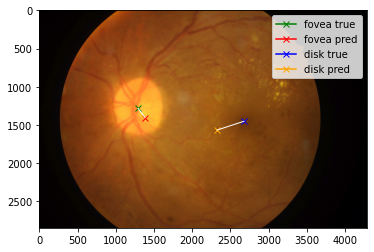

In [45]:
plot = lambda img: einops.rearrange(img, "c w h -> w h c")
def norm2pixel(norm): 
    return (
        int(norm[0].item()*4288), 
        int(norm[1].item()*2848), 
        int(norm[2].item()*4288), 
        int(norm[3].item()*2848)
    )

fx, fy, dx, dy = norm2pixel(labels)
fpx, fpy, dpx, dpy = norm2pixel(preds)


plt.plot(fx, fy, marker='x', color="green")
plt.plot(fpx, fpy, marker='x', color="red")
plt.plot(dx, dy, marker='x', color="blue")
plt.plot(dpx, dpy, marker='x', color="orange")
plt.legend(["fovea true", "fovea pred", "disk true", "disk pred"])
plt.plot([fx,fpx], [fy,fpy], color="white", linewidth=1)
plt.plot([dx, dpx], [dy, dpy], color="white", linewidth=1)
plt.imshow(plot(img))
plt.show()